In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [132]:
df = pd.read_csv('data.csv')
df = df.rename(columns={r'conversion': r'target', r'offer': r'treatment'})
df.treatment = df.treatment.map({r'No Offer': 0, r'Buy One Get One': 1, r'Discount': 1})
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [133]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df.target, test_size=0.3, random_state=42)
treat_train = X_train.treatment
treat_test = X_test.treatment
# X_train = X_train.drop(columns=[r'treatment'])
# X_test = X_test.drop(columns=[r'treatment'])

4. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями

In [134]:
models_results = {
    r'model': [],
    r'uplift@10%': [],
    r'uplift@20%': []
    }
cat_features = [
    'zip_code',
    'channel'
    ]

In [135]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
models_results[r'model'].append(r'SoloModel')
models_results[r'uplift@10%'].append(sm_score_10)
models_results[r'uplift@20%'].append(sm_score_20)

In [136]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)
ct = ct.fit(X_train, y_train, treat_train)
uplift_ct = ct.predict(X_test)
ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
models_results[r'model'].append(r'ClassTransformation')
models_results[r'uplift@10%'].append(ct_score_10)
models_results[r'uplift@20%'].append(ct_score_20)

In [137]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)
uplift_tm = tm.predict(X_test)
tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
models_results[r'model'].append(r'TwoModels')
models_results[r'uplift@10%'].append(tm_score_10)
models_results[r'uplift@20%'].append(tm_score_20)

5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [138]:
final_results = pd.DataFrame(models_results)
final_results

,model,uplift@10%,uplift@20%
0,SoloModel,0.122913,0.100633
1,ClassTransformation,0.273450,0.227711
2,TwoModels,0.109515,0.091545


6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

In [139]:
test_final = pd.DataFrame({r'target': y_test, r'uplift': uplift_sm})
test_final = test_final.sort_values(by=['uplift'], ascending=False)
test_final[r'decile'] = pd.qcut(test_final[r'uplift'], 10, labels=False)
out = test_final.groupby(r'decile', as_index=False)['target'].mean().rename(columns={r'target': r'mean_target'})
out_final = out.merge(test_final, on='decile', how = 'inner')
out_final = out_final.drop_duplicates(subset=['decile'])

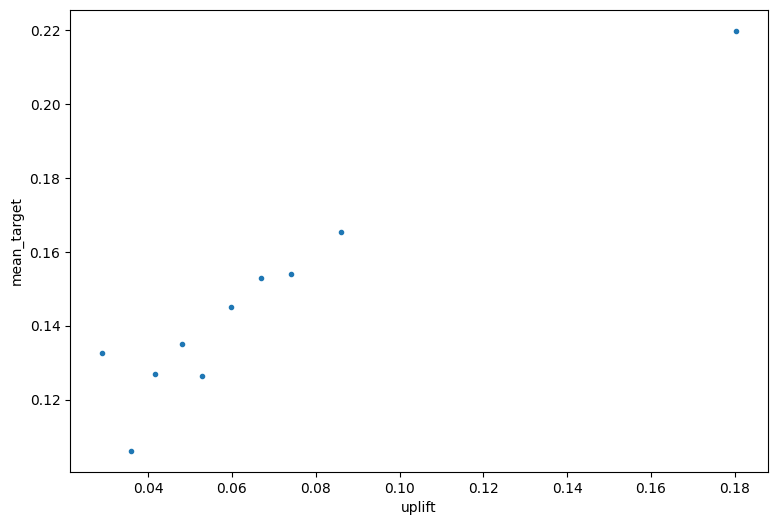

In [140]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_xlabel(r'uplift')
ax.set_ylabel(r'mean_target')
ax.plot(out_final.uplift, out_final.mean_target, '.')
plt.show()